<a href="https://colab.research.google.com/github/trista-paul/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/Survival_Analysis_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Lecture summary
#Probability density function

#Example: Hazard function
#"instantaneous likelihood of failure" ex.lifetime mortality U curve

#Cumulative Distribution Function
#CDF is the integral of the PDF
#it is the area under the curve of sigmoid
#y P event less than or equal to x

#example: Survival function
#Survival analysis is applied to retention; also known as time to event
#birth, death are general terms for the interval
#birth: person issued welfare
#death: person improoves income and is no longer eligible
#survival answers how long the interval they are on welfare
#'data censorship' occurs when subject doesn't trigger death event
#or literally dies
#logistic reg doesn't have a way to interpret censorship, and survival barely does
#defaulting end of period as death or dropping are both bad

# Assignment - Customer Churn

Treselle Systems, a data consulting service, [analyzed customer churn data using logistic regression](http://www.treselle.com/blog/customer-churn-logistic-regression-with-r/). For simply modeling whether or not a customer left this can work, but if we want to model the actual tenure of a customer, survival analysis is more appropriate.

The "tenure" feature represents the duration that a given customer has been with them, and "churn" represents whether or not that customer left (i.e. the "event", from a survival analysis perspective). So, any situation where churn is "no" means that a customer is still active, and so from a survival analysis perspective the observation is censored (we have their tenure up to now, but we don't know their *true* duration until event).

Your assignment is to [use their data](https://github.com/treselle-systems/customer_churn_analysis) to fit a survival model, and answer the following questions:

- What features best model customer churn?
- What would you characterize as the "warning signs" that a customer may discontinue service?
- What actions would you recommend to this business to try to improve their customer retention?

Please create at least *3* plots or visualizations to support your findings, and in general write your summary/results targeting an "interested layperson" (e.g. your hypothetical business manager) as your audience.

This means that, as is often the case in data science, there isn't a single objective right answer - your goal is to *support* your answer, whatever it is, with data and reasoning.

Good luck!

In [1]:
!pip install lifelines

    100% |████████████████████████████████| 266kB 11.1MB/s 


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines
cph = lifelines.CoxPHFitter()

In [54]:
# Loading the data to get you started
df = pd.read_csv(
    'https://raw.githubusercontent.com/treselle-systems/'
    'customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', None)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [55]:
#cell that does all cleaning operations at once
#key for classes below
#I erased the work because I redid the cleaning from a new angle Wednesday night
#and the notebook was huge and depressing

#basics - drop id and convert totalcharge to float
df = df.drop(columns = ['customerID'])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

#convert special classes into numeric
Classes = ['gender', 'InternetService', 'Contract', 'PaymentMethod']
classes = df[Classes]
df = df.drop(columns=Classes)

for label, col in classes.iteritems():
  n = 0
  for types in col.unique():
      col = col.replace({types:n})
      n = n+1
  classes[label] = col
  
#manually assign Internet Service so None is 0
classes['InternetService'] = classes['InternetService'].replace({2:0, 0:2})

#convert remaining objects, binaries, into 0 for No and 1 for Yes
objects = df.select_dtypes(include=object)
notobjects = df.select_dtypes(exclude=object)

objects = objects.replace({'Yes': str(1), 'No': str(0), 'No internet service':str(0), 'No phone service':str(0)})
for label, col in objects.iteritems():
  col = pd.to_numeric(col, errors='coerce')
  objects[label] = col

#concat objects, notobjects and classes
df = pd.concat([objects, notobjects], axis=1)
df = pd.concat([df, classes], axis=1)
df = df.dropna()
df.head()

,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Churn,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender,InternetService,Contract,PaymentMethod
0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,29.85,29.85,0,2,0,0
1,0,0,1,0,1,0,1,0,0,0,0,0,0,34,56.95,1889.50,1,2,1,1
2,0,0,1,0,1,1,0,0,0,0,1,1,0,2,53.85,108.15,1,2,0,1
3,0,0,0,0,1,0,1,1,0,0,0,0,0,45,42.30,1840.75,1,2,1,2
4,0,0,1,0,0,0,0,0,0,0,1,1,0,2,70.70,151.65,0,1,0,0


In [47]:
#convert special classes into numeric
Classes = ['gender', 'InternetService', 'Contract', 'PaymentMethod']
classes = df[Classes]
for label, col in classes.iteritems():
  print(col.value_counts())
  n = 0
  for types in col.unique():
      col = col.replace({types:n})
      n = n+1
  classes[label] = col
  print(classes[label].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64
1    3555
0    3488
Name: gender, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
1    3096
0    2421
2    1526
Name: InternetService, dtype: int64
Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0    3875
2    1695
1    1473
Name: Contract, dtype: int64
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64
0    2365
1    1612
2    1544
3    1522
Name: PaymentMethod, dtype: int64


In [48]:
classes['InternetService'] = classes['InternetService'].replace({2:0, 0:2})
classes['InternetService'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1    3096
2    2421
0    1526
Name: InternetService, dtype: int64

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
Partner             7032 non-null int64
Dependents          7032 non-null int64
PhoneService        7032 non-null int64
MultipleLines       7032 non-null int64
OnlineSecurity      7032 non-null int64
OnlineBackup        7032 non-null int64
DeviceProtection    7032 non-null int64
TechSupport         7032 non-null int64
StreamingTV         7032 non-null int64
StreamingMovies     7032 non-null int64
PaperlessBilling    7032 non-null int64
Churn               7032 non-null int64
SeniorCitizen       7032 non-null int64
tenure              7032 non-null int64
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
gender              7032 non-null int64
InternetService     7032 non-null int64
Contract            7032 non-null int64
PaymentMethod       7032 non-null int64
dtypes: float64(2), int64(18)
memory usage: 1.1 MB


In [57]:
df.describe()

,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Churn,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender,InternetService,Contract,PaymentMethod
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.482509,0.298493,0.903299,0.421928,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.592719,0.265785,0.162400,32.421786,64.798208,2283.300441,0.504693,1.127418,0.688567,1.315557
std,0.499729,0.457629,0.295571,0.493902,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.491363,0.441782,0.368844,24.545260,30.085974,2266.771362,0.500014,0.737271,0.832934,1.149523
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,35.587500,401.450000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,29.000000,70.350000,1397.475000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,55.000000,89.862500,3794.737500,1.000000,2.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,118.750000,8684.800000,1.000000,2.000000,2.000000,3.000000


In [58]:
cph = lifelines.CoxPHFitter()
cph.fit(df, 'tenure', event_col='Churn')
cph.print_summary()
#something is happening with onlinebackup, partner and phoneservice.
#their likelihood to cancel increases in response to small changes in unit
#probably irrelevant (likelihood change is or near 1 w low coefs):
#totalcharges, gender, senior, monthlycharges

#low P club! (under 0.05)
#let's start improving the model by reducing features to these
#Partner, PhoneService, MultipleLines, OnlineSecurity, OnlineBackup,
#TechSupport, Contract
#PaperlessBilling, PaymentMethod, MonthlyCharges
#TotalCharges just seems to act unusual

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -12686.11
  time fit was run = 2019-02-28 08:53:54 UTC

---
                  coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
Partner          -0.20       0.82      0.05  -3.58 <0.005     11.49       -0.30       -0.09
Dependents       -0.07       0.93      0.07  -1.07   0.28      1.81       -0.21        0.06
PhoneService     -0.26       0.77      0.12  -2.14   0.03      4.93       -0.50       -0.02
MultipleLines    -0.21       0.81      0.05  -3.95 <0.005     13.62       -0.32       -0.11
OnlineSecurity   -0.48       0.62      0.07  -6.95 <0.005     37.96       -0.62       -0.34
OnlineBackup     -0.34       0.71      0.06  -6.04 <0.005     29.25       -0.45       -0.23
DeviceProtection -0.18       0.83      0.06  -3.23 <0.005      9.65       -0.29       -0.07
Te

In [59]:
LowPClub = ['tenure', 'Churn',
            'Partner', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
            'OnlineBackup', 'TechSupport', 'Contract', 'PaperlessBilling',
            'PaymentMethod', 'MonthlyCharges']
dfnew = df[LowPClub]
dfnew.head(1)

,tenure,Churn,Partner,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,1,0,1,0,0,0,1,0,0,1,0,29.85


In [60]:
cph.fit(dfnew, 'tenure', event_col='Churn')
cph.print_summary()
#like I thought MonthlyCharges wasn't really that relevant
#but had inflated P significance

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -13966.13
  time fit was run = 2019-02-28 08:54:37 UTC

---
                  coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
Partner          -0.59       0.56      0.05 -11.68 <0.005    102.33       -0.68       -0.49
PhoneService     -0.02       0.98      0.09  -0.25   0.80      0.32       -0.21        0.16
MultipleLines    -0.51       0.60      0.06  -9.18 <0.005     64.38       -0.62       -0.40
OnlineSecurity   -0.60       0.55      0.07  -9.21 <0.005     64.79       -0.73       -0.47
OnlineBackup     -0.70       0.50      0.06 -12.43 <0.005    115.43       -0.81       -0.59
TechSupport      -0.46       0.63      0.06  -7.13 <0.005     39.85       -0.59       -0.34
Contract         -1.79       0.17      0.06 -28.26 <0.005    581.38       -1.92       -1.67
Pa

In [61]:
dfnew = dfnew.drop(columns=['MonthlyCharges', 'Contract'])

cph.fit(dfnew, 'tenure', event_col='Churn')
cph.print_summary()
#The exp(coef) of these features is closer to reality now
#PhoneService, OnlineBackup and Partner are largest changes

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -13997.12
  time fit was run = 2019-02-28 08:54:44 UTC

---
                  coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
Partner          -0.57       0.57      0.05 -11.34 <0.005     96.66       -0.67       -0.47
PhoneService      0.25       1.28      0.09   2.90 <0.005      8.06        0.08        0.41
MultipleLines    -0.33       0.72      0.05  -6.46 <0.005     33.13       -0.43       -0.23
OnlineSecurity   -0.54       0.58      0.06  -8.29 <0.005     53.02       -0.66       -0.41
OnlineBackup     -0.58       0.56      0.05 -10.69 <0.005     86.12       -0.69       -0.48
TechSupport      -0.35       0.70      0.06  -5.53 <0.005     24.87       -0.47       -0.23
Contract         -1.88       0.15      0.06 -30.24 <0.005    664.75       -2.01       -1.76
Pa

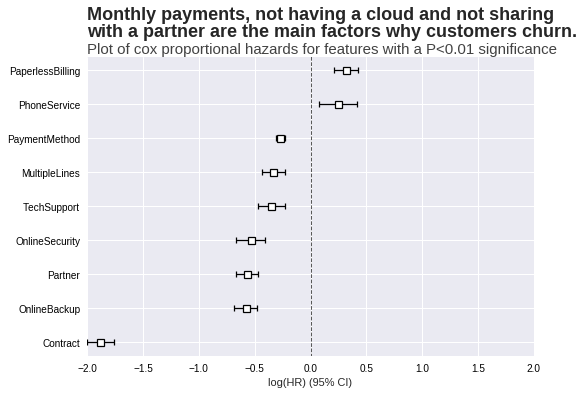

In [63]:
ax = cph.plot();
plt.xlim(-2, 2)
ax.tick_params(axis='both', labelcolor='black')
ax.text(x = -2, y=9.5, s='Monthly payments, not having a cloud and not sharing',
        fontsize=18, fontweight='bold');
ax.text(x = -2, y=9, s='with a partner are the main factors why customers churn.',
        fontsize=18, fontweight='bold');
ax.text(x = -2, y=8.5, s='Plot of cox proportional hazards for features with a P<0.01 significance',
        fontsize=15, color='#424242');
#the confidence interval of feature coefficient

In [64]:
!pip install -U matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.0.2)


In [65]:
time = dfnew.tenure.values
event = dfnew.Churn.values

kmf = lifelines.KaplanMeierFitter()

kmf.fit(time, event_observed=event)

<lifelines.KaplanMeierFitter: fitted with 7032 observations, 5163 censored>

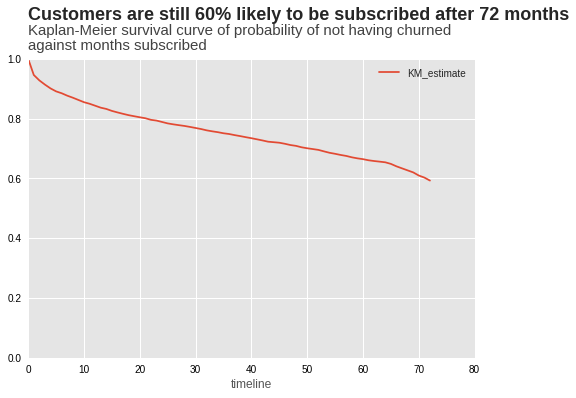

In [66]:
plt.style.use('ggplot')
ax = kmf.survival_function_.plot()
plt.ylim(0.00, 1.00)
plt.xlim(0, 80)
ax.tick_params(axis='both', labelcolor='black')
ax.text(x = 0, y=1.13, s='Customers are still 60% likely to be subscribed after 72 months',
        fontsize=18, fontweight='bold');
ax.text(x = 0, y=1.08, s='Kaplan-Meier survival curve of probability of not having churned',
        fontsize=15, color='#424242');
ax.text(x = 0, y=1.03, s='against months subscribed',
        fontsize=15, color='#424242');

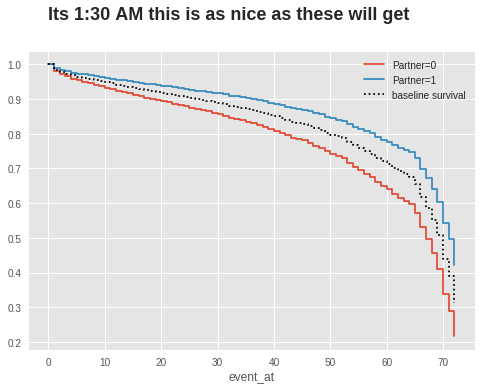

In [72]:
ax = cph.plot_covariate_groups(covariates='Partner', values=[0,1]);
ax.text(x = 0, y=1.13, s='Its 1:30 AM this is as nice as these will get',
        fontsize=18, fontweight='bold');

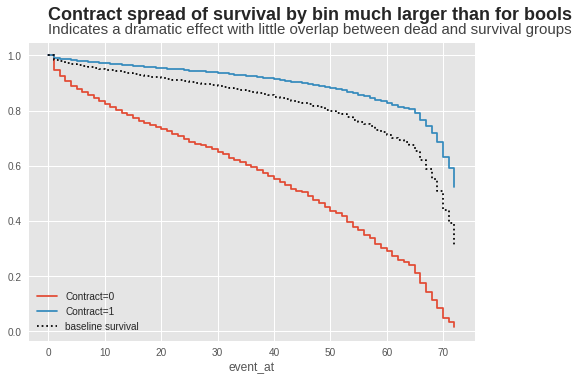

In [74]:
ax = cph.plot_covariate_groups(covariates='Contract', values=np.arange(0,2,1));
ax.text(x = 0, y=1.13, s='Contract spread of survival by bin much larger than for bools',
        fontsize=18, fontweight='bold');
ax.text(x = 0, y=1.08, s='Indicates a dramatic effect with little overlap between dead and survival groups',
        fontsize=15, color='#424242');
#spread of survival by bin nearly identical to partner

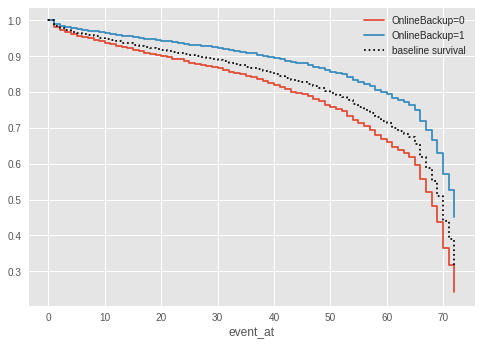

In [73]:
cph.plot_covariate_groups(covariates='OnlineBackup', values=[0,1])
#spread of survival by bin nearly identical to partner

Most of the features I looked at are what's called 'binary' or 'boolean' in the programming world - they either have a yes or no answer. Their numeric symbolism is 1 and 0. Two of the most impactful features on churn (above 0.5 or below -0.5 on the Cox hazards graph), sharing with a partner or using the phone service, are boolean. Our negative placement of partner on the cox hazards graph means that we are more at risk of losing a customer if they are not sharing it with another adult. This makes intuitive sense and there isn't a lot that can be done about it other than making our online service show more Hot Singles In Your Area (don't do this). OnlineBackup has a nearly identical placement, but's its worth saying it was originally three conditions (cloud - 1, not having cloud but having internet service - 0, not having internet service - 0). Pure booleans like partner sharing are probably slightly more accurate models of churn than compressed ones like online backup use or pure categorical classes like contract type.

By far the most dramatic feature either direction is the contract type, where I mapped 0 (and that strongly negative trend) to the **month-by-month payment**, 1 to payment per 1 year, and 2 to payment by 2 years. This also makes sense, as there are more opportunities to withdrawl than with annual plans.

I advise you to look into how we incentivize customers, particularly existing monthly customers, to our annual plans and cloud services. This strategy could look like offering discounts on cloud frequently and marketing the pricing-per-month of the annual plans as clearly more cost-effective than the monthly or the competition.